In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from back_tester import * 
from deep_q_learning_improved import *
from collections import Counter


/opt/anaconda3/envs/main_conda_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Fix seed for reproducibility
---

In [2]:
# ─── FIX RANDOM SEEDS ───────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED) #Sets the seed for Python’s built-in random module.
np.random.seed(SEED) #Sets the seed for NumPy’s random number generator.
torch.manual_seed(SEED) #Sets the seed for PyTorch CPU operations.
# if you’re using CUDA:
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # make CuDNN deterministic (may slow you down a bit)
    torch.backends.cudnn.deterministic   = True
    torch.backends.cudnn.benchmark       = False
# ────────────────────────────────────────────────────────────────────────────────



# Load data
---

* ## In sample data

In [3]:
#Data
#prices = pd.read_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index_col=0, parse_dates=True)
prices = pd.read_csv('tardis_data/final_training_set/final_training_set_5min_2024.csv', index_col=0,parse_dates=True)
prices = prices[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]

#Filter for AXSUSDT_2024_5m ~ SANDUSDT_2024_5m
#prices = prices[['AXSUSDT_2024_5m', 'SANDUSDT_2024_5m']]
prices

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-01-01 00:00:00,0.5239,0.6006
2024-01-01 00:05:00,0.5228,0.5971
2024-01-01 00:10:00,0.5228,0.5979
2024-01-01 00:15:00,0.5213,0.5941
2024-01-01 00:20:00,0.5218,0.5947
...,...,...
2024-12-31 23:35:00,0.4651,0.5445
2024-12-31 23:40:00,0.4661,0.5451
2024-12-31 23:45:00,0.4669,0.5466


* ## Out of sample data

In [4]:
#prices_out_of_sample = pd.read_csv('tardis_data/final_out_of_sample_dataset_5min/final_out_of_sample_dataset_5min.csv', index_col=0, parse_dates=True)
prices_out_of_sample = pd.read_csv('tardis_data/final_testing_set/final_test_set_5min_2025.csv',index_col=0, parse_dates=True)
#Filter for MANAUSDT_2024_5m ~ SANDUSDT_2024_5m
prices_out_of_sample = prices_out_of_sample[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]
prices_out_of_sample

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2025-01-01 00:00:00,0.4692,0.5480
2025-01-01 00:05:00,0.4691,0.5489
2025-01-01 00:10:00,0.4698,0.5486
2025-01-01 00:15:00,0.4696,0.5499
2025-01-01 00:20:00,0.4695,0.5486
...,...,...
2025-03-30 23:35:00,0.2454,0.2696
2025-03-30 23:40:00,0.2469,0.2701
2025-03-30 23:45:00,0.2465,0.2697


# EDD
---

In [5]:
# # Load your precomputed z-score spreads and raw prices as NumPy arrays

# window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!


# sym1, sym2 = prices.columns
# S1 = prices[sym1]
# S2 = prices[sym2]

# print("Computing spread series and beta series...")
# # Compute the spread series and beta_series 
# spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
# #print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# # Compute rolling z-score using the provided helper function.
# zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

# #Drop NaN values from zscore_series
# zscore_series = zscore_series.dropna()

# #Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
# prices = prices.loc[zscore_series.index]
# beta_series = beta_series.loc[zscore_series.index]


In [6]:
# # 1) Prepare a DataFrame to collect per‐cycle features

# spreads = zscore_series


# records = []
# for period, month_df in spreads.groupby(spreads.index.to_period("M")):
#     # slice out that month’s data
#     z = spreads[spreads.index.to_period("M") == period]
#     p = prices.loc[z.index]
#     b = beta_series.loc[z.index]

#     # build a mini‐env just to extract cycles
#     env = PairsTradingEnv(z, p, b, initial_capital=1.0, tx_cost=0.0, entry_stop_pairs=[(1, 2), (2, 3), (3, 4)], eval_mode=True) #Make eval mode false for now
#     env.create_cycles(min_threshold=1.0, tol=0.10)

#     # for each cycle, grab summary stats
#     for cycle in env.spread_cycles:
#         records.append({
#             "month": str(period),
#             "entry_z": cycle.iloc[0],
#             "cycle_mean": cycle.mean(),
#             "cycle_std": cycle.std(),
#             "cycle_length": len(cycle),
#             "cycle_min": cycle.min(),
#             "cycle_max": cycle.max(),
#             "Absolute max": max(cycle.max(), abs(cycle.min())),
#         })

# df_cycles = pd.DataFrame(records)

In [7]:
# df_cycles

In [8]:

# # 2) Look at how entry_z distributions shift month→month
# plt.figure(figsize=(10,6))
# df_cycles.boxplot(column="entry_z", by="month", rot=45)
# plt.title("Distribution of Cycle Entry Z‐Scores by Month")
# plt.suptitle(""); plt.ylabel("Entry Z-Score")
# plt.tight_layout()
# plt.show()

# # 3) Similarly you can do cycle_length, cycle_std, etc.
# for feat in ["cycle_length","cycle_std","cycle_min","cycle_max"]:
#     plt.figure(figsize=(10,4))
#     df_cycles.boxplot(column=feat, by="month", rot=45)
#     plt.title(f"{feat} by Month")
#     plt.suptitle(""); plt.ylabel(feat)
#     plt.tight_layout()
#     plt.show()

# # 4) Or even a heatmap of mean/std per month
# summary = df_cycles.groupby("month")[["entry_z","cycle_length","cycle_std"]].agg(["mean","std"])
# print(summary)


* ## Training set

---

In [9]:

#prices_train = prices.loc['2024-01-01 00:00:00':'2024-04-30 23:55:00'] #January training data

#prices_train = prices.loc['2024-01-01 00:00:00':'2024-05-30 23:55:00'] #January training data

prices_train = prices

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_train, sym2_train = prices_train.columns
S1_train = prices_train[sym1_train]
S2_train = prices_train[sym2_train]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_train, beta_series_train, alpha_series_train = compute_spread_series(S1_train, S2_train, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_train, rolling_mean_train, rolling_std_train = compute_rolling_zscore(spread_series_train, window_size)

#Drop NaN values from zscore_series
zscore_series_train = zscore_series_train.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_train = prices_train.loc[zscore_series_train.index]
beta_series_train = beta_series_train.loc[zscore_series_train.index]



Computing spread series and beta series...


In [10]:
prices_train

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-01-03 00:50:00,0.5315,0.5883
2024-01-03 00:55:00,0.5323,0.5892
2024-01-03 01:00:00,0.5331,0.5904
2024-01-03 01:05:00,0.5327,0.5897
2024-01-03 01:10:00,0.5323,0.5899
...,...,...
2024-12-31 23:35:00,0.4651,0.5445
2024-12-31 23:40:00,0.4661,0.5451
2024-12-31 23:45:00,0.4669,0.5466


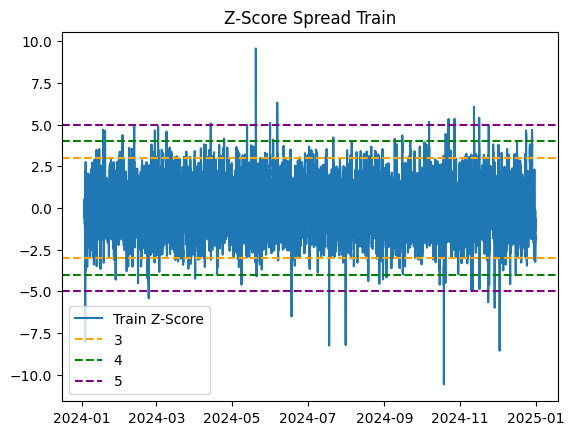

In [11]:
plt.plot(zscore_series_train, label='Train Z-Score')
plt.axhline(3, color='orange', linestyle='--', label='3')
plt.axhline(-3, color='orange', linestyle='--')
plt.axhline(4, color='g', linestyle='--', label='4')
plt.axhline(-4, color='g', linestyle='--',)
plt.axhline(5, color='purple', linestyle='--', label='5')
plt.axhline(-5, color='purple', linestyle='--')
plt.title('Z-Score Spread Train')
plt.legend()

---

* ## Validation set

---

In [12]:

#prices_val = prices.loc['2024-05-01 00:00:00':'2024-05-31 23:55:00'] #May val data
#prices_val = prices.loc['2024-06-01 00:00:00':'2024-06-30 23:55:00'] #May val data
prices_val = prices_out_of_sample.loc['2025-01-01 00:00:00':'2025-02-28 23:55:00'] #January-Feb 2025 val data


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_val, sym2_val = prices_val.columns
S1_val = prices_val[sym1_val]
S2_val = prices_val[sym2_val]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_val, beta_series_val, alpha_series_val = compute_spread_series(S1_val, S2_val, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_val, rolling_mean_val, rolling_std_val = compute_rolling_zscore(spread_series_val, window_size)

#Drop NaN values from zscore_series
zscore_series_val = zscore_series_val.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_val = prices_val.loc[zscore_series_val.index]
beta_series_val = beta_series_val.loc[zscore_series_val.index]


Computing spread series and beta series...


In [13]:
prices_val

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2025-01-03 00:00:00,0.5066,0.5850
2025-01-03 00:05:00,0.5070,0.5850
2025-01-03 00:10:00,0.5075,0.5847
2025-01-03 00:15:00,0.5070,0.5832
2025-01-03 00:20:00,0.5069,0.5836
...,...,...
2025-02-28 23:35:00,0.2976,0.3202
2025-02-28 23:40:00,0.2975,0.3204
2025-02-28 23:45:00,0.2965,0.3197


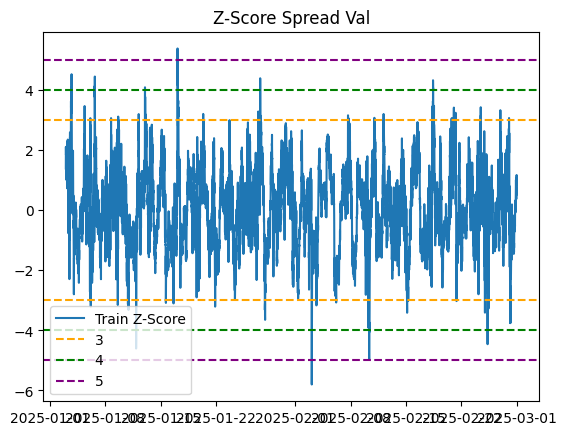

In [14]:
plt.plot(zscore_series_val, label='Train Z-Score')
plt.axhline(3, color='orange', linestyle='--', label='3')
plt.axhline(-3, color='orange', linestyle='--')
plt.axhline(4, color='g', linestyle='--', label='4')
plt.axhline(-4, color='g', linestyle='--',)
plt.axhline(5, color='purple', linestyle='--', label='5')
plt.axhline(-5, color='purple', linestyle='--')
plt.title('Z-Score Spread Val')
plt.legend()

---

* ## Test set

---

In [15]:

#prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-29 23:55:00']
#prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-30 23:55:00']

#prices_test = prices.loc['2024-05-01 00:00:00':'2024-06-30 23:55:00'] #May and June test data

#Test set is the out-of-sample data
prices_test = prices_out_of_sample.loc['2025-03-01 00:00:00':'2025-03-31 23:55:00'] #March 2025 test data

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_test, sym2_test = prices_test.columns
S1_test = prices_test[sym1_test]
S2_test = prices_test[sym2_test]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_test, beta_series_test, alpha_series_test = compute_spread_series(S1_test, S2_test, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_test, rolling_mean_test, rolling_std_test = compute_rolling_zscore(spread_series_test, window_size)

#Drop NaN values from zscore_series
zscore_series_test = zscore_series_test.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_test = prices_test.loc[zscore_series_test.index]
beta_series_test = beta_series_test.loc[zscore_series_test.index]


Computing spread series and beta series...


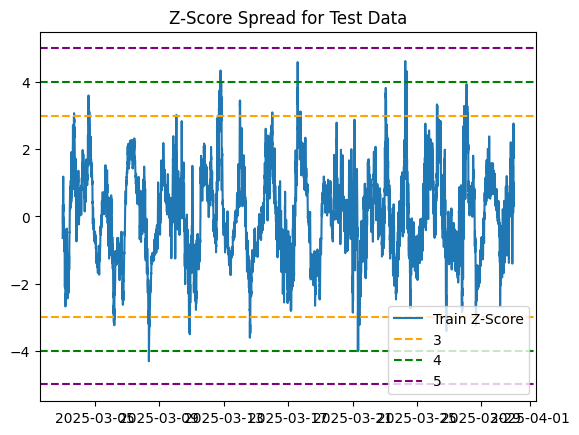

In [16]:
plt.plot(zscore_series_test, label='Train Z-Score')
plt.axhline(3, color='orange', linestyle='--', label='3')
plt.axhline(-3, color='orange', linestyle='--')
plt.axhline(4, color='g', linestyle='--', label='4')
plt.axhline(-4, color='g', linestyle='--',)
plt.axhline(5, color='purple', linestyle='--', label='5')
plt.axhline(-5, color='purple', linestyle='--')
plt.title('Z-Score Spread for Test Data')
plt.legend()

---

# Train agent
---

In [17]:

print("Training DQN agent...")
# Define your discrete threshold pairs: [(entry1, stop1), (entry2, stop2), ...]
entry_stop_pairs = [(1, 2), (2, 3),(3, 4),(4,5)]
# Training parameters
initial_capital = 10_000
tx_cost = 0

online_net, replay_buffer,epoch_loss_history, reward_history,validation_reward_history,training_metrics = train_dqn(
                                                                                        zscore_series_train, 
                                                                                        prices_train, 
                                                                                        beta_series_train,
                                                                                        zscore_series_val,
                                                                                        prices_val,
                                                                                        beta_series_val,
                                                                                        initial_capital,
                                                                                        tx_cost,
                                                                                        entry_stop_pairs, 
                                                                                        num_epochs=220,
                                                                                        batch_size=32,
                                                                                        gamma = 0.99,
                                                                                        lr = 0.001,
                                                                                        epsilon_start = 1,
                                                                                        epsilon_end = 0.01,
                                                                                        epsilon_decay = 0.995,
                                                                                        replay_capacity = 1000,
                                                                                        target_update_freq = 10,
                                                                                        hidden_dim = 64,
                                                                                        tau= 0.01,                                           
                                                                                        )

# Save the trained model
torch.save(online_net.state_dict(), 'dqn_model.pth')


Training DQN agent...
Number of cycles: 1445
Epoch 01 | AvgReward: -0.53 | Epsilon: 0.995
Epoch 02 | AvgReward: -0.46 | Epsilon: 0.990
Epoch 03 | AvgReward: -0.51 | Epsilon: 0.985
Epoch 04 | AvgReward: -0.51 | Epsilon: 0.980
Epoch 05 | AvgReward: -0.53 | Epsilon: 0.975
Epoch 06 | AvgReward: -0.46 | Epsilon: 0.970
Epoch 07 | AvgReward: -0.52 | Epsilon: 0.966
Epoch 08 | AvgReward: -0.46 | Epsilon: 0.961
Epoch 09 | AvgReward: -0.47 | Epsilon: 0.956
Epoch 10 | AvgReward: -0.47 | Epsilon: 0.951
Epoch 11 | AvgReward: -0.48 | Epsilon: 0.946
Epoch 12 | AvgReward: -0.44 | Epsilon: 0.942
Epoch 13 | AvgReward: -0.46 | Epsilon: 0.937
Epoch 14 | AvgReward: -0.48 | Epsilon: 0.932
Epoch 15 | AvgReward: -0.49 | Epsilon: 0.928
Epoch 16 | AvgReward: -0.45 | Epsilon: 0.923
Epoch 17 | AvgReward: -0.44 | Epsilon: 0.918
Epoch 18 | AvgReward: -0.41 | Epsilon: 0.914
Epoch 19 | AvgReward: -0.45 | Epsilon: 0.909
Epoch 20 | AvgReward: -0.42 | Epsilon: 0.905
Epoch 21 | AvgReward: -0.48 | Epsilon: 0.900
Epoch 22 |

In [18]:
# n_trials = 10
# num_epochs = 220

# best_reward, best_params = optimize_hyperparameters(
#     zscore_series_train, prices_train, beta_series_train,
#     zscore_series_val,   prices_val,   beta_series_val,
#     initial_capital, tx_cost,
#     entry_stop_pairs,
#     n_trials,
#     num_epochs
# )

In [19]:
# lr_best, batch_size_best, hidden_dim_best, gamma_best, epsilon_decay_best, tau_best = best_params.values()

# print(f"Best reward: {best_reward}")
# print(f"Best hyperparameters: {best_params.values()}")
# # Train the DQN agent with the best hyperparameters

# #lr_best, batch_size_best, hidden_dim_best, gamma_best, epsilon_decay_best, tau_best = 0.00010366806196026195, 16, 32, 0.9811910981039401, 0.9906752554940417, 0.007164004897848127



In [20]:

# online_net, replay_buffer,epoch_loss_history, reward_history,validation_reward_history,training_metrics = train_dqn(
#                                                                                         zscore_series_train, 
#                                                                                         prices_train, 
#                                                                                         beta_series_train,
#                                                                                         zscore_series_val,
#                                                                                         prices_val,
#                                                                                         beta_series_val,
#                                                                                         initial_capital,
#                                                                                         tx_cost,
#                                                                                         entry_stop_pairs, 
#                                                                                         num_epochs=num_epochs,
#                                                                                         batch_size=batch_size_best,
#                                                                                         gamma = gamma_best,
#                                                                                         lr = lr_best,
#                                                                                         epsilon_start = 1,
#                                                                                         epsilon_end = 0.01,
#                                                                                         epsilon_decay = epsilon_decay_best,
#                                                                                         replay_capacity = 1000,
#                                                                                         target_update_freq = 10,
#                                                                                         hidden_dim = hidden_dim_best,
#                                                                                         tau= tau_best,                                           
#                                                                                         )

# # Save the trained model
# torch.save(online_net.state_dict(), 'dqn_model.pth')

In [21]:
# training_metrics_temp = training_metrics.copy()

In [22]:
entry_stop_pairs_extended = [(1, 2), (2, 3),(3, 4),(4,5),(5,6),(6,7),(7,8),(8,9),(9,10)]

# Best thresholds
---

In [23]:
# env = PairsTradingEnv(zscore_series_train, prices_train, beta_series_train, initial_capital, tx_cost, entry_stop_pairs_extended, eval_mode=True) #keep eval_mode=True so no cylces are removed
# best_pairs_train = env.find_best_thresholds()
# spread_cycles_train = env.spread_cycles

# #best_pairs_train = find_best_thresholds(entry_stop_pairs,zscore_series_train,prices_train,beta_series_train)

# # Suppose best_pairs is your list of length N containing either (e,s) or None
# counts = Counter(best_pairs_train)   # Now counts[None] is how many cycles had no winning pair
# total  = len(best_pairs_train)

# # Convert raw counts to percentages
# pairs    = list(counts.keys())
# percent_train  = [counts[p] / total * 100 for p in pairs]

# # Turn None → a string label
# labels = [
#     "no winner" if p is None else f"{p[0]},{p[1]}"
#     for p in pairs
# ]

# zip_object = zip(labels, percent_train)

# print("Percentage Counts")
# print("---------------------")
# print(percent_train)

# print("Numerical counts")
# print("---------------------")
# print([counts[p] for p in pairs])


# # Plot
# plt.figure(figsize=(8,6))
# bars = plt.bar(range(len(labels)), percent_train, tick_label=labels)
# plt.ylabel("% of cycles")
# plt.xlabel("(entry, stop) pair")

# #Add value labels on top of the bars
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')
# plt.xticks(rotation=45)
# plt.title("Best Entry–Stop Pair Coverage (Training set)")

# plt.tight_layout()





In [24]:
# env_val_best = PairsTradingEnv(zscore_series_val, prices_val, beta_series_val, initial_capital, tx_cost, entry_stop_pairs_extended, eval_mode=True)
# best_pairs_val = env_val_best.find_best_thresholds()
# spread_cycles_val = env_val_best.spread_cycles


# # Suppose best_pairs is your list of length N containing either (e,s) or None
# counts = Counter(best_pairs_val)   # Now counts[None] is how many cycles had no winning pair
# total  = len(best_pairs_val)

# # Convert raw counts to percentages
# pairs    = list(counts.keys())
# percent_val  = [counts[p] / total * 100 for p in pairs]

# # Turn None → a string label
# labels = [
#     "no winner" if p is None else f"{p[0]},{p[1]}"
#     for p in pairs
# ]

# print("Percentage Counts")
# print("---------------------")
# print(percent_val)


# print("Numerical counts")
# print("---------------------")
# print([counts[p] for p in pairs])



# # Plot
# plt.figure(figsize=(8,6))
# bars = plt.bar(range(len(labels)), percent_val, tick_label=labels)

# #Add percentage values on top of the bars
# for bar, percent in zip(bars, percent_val):
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{percent:.1f}%", ha='center', va='bottom')


# plt.ylabel("% of cycles")
# plt.xlabel("(entry, stop) pair")
# plt.title("Best Entry–Stop Pair Coverage (Validation set))")

In [25]:
# env_test_best = PairsTradingEnv(zscore_series_test, prices_test, beta_series_test, initial_capital, tx_cost, entry_stop_pairs_extended, eval_mode=True)
# best_pairs_test = env_test_best.find_best_thresholds()
# spread_cycles_test = env_test_best.spread_cycles


# # Suppose best_pairs is your list of length N containing either (e,s) or None
# counts = Counter(best_pairs_test)   # Now counts[None] is how many cycles had no winning pair
# total  = len(best_pairs_test)

# # Convert raw counts to percentages
# pairs    = list(counts.keys())
# percent_test  = [counts[p] / total * 100 for p in pairs]

# # Turn None → a string label
# labels = [
#     "no winner" if p is None else f"{p[0]},{p[1]}"
#     for p in pairs
# ]

# print("Percentage Counts")
# print("---------------------")
# print(percent_test)


# print("Numerical counts")
# print("---------------------")
# print([counts[p] for p in pairs])



# # Plot
# plt.figure(figsize=(8,6))
# bars = plt.bar(range(len(labels)), percent_test, tick_label=labels)
# plt.ylabel("% of cycles")
# plt.xlabel("(entry, stop) pair")

# #Add percentage text on top of each bar
# for bar, percent in zip(bars, percent_test):
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{percent:.1f}%", ha='center', va='bottom')
    
# plt.title("Best Entry–Stop Pair Coverage (Test set)")
# plt.tight_layout()




In [26]:
# plt.plot(zscore_series_train.iloc[0:420], color = 'grey', label='Z-Score Series')
# plt.plot(spread_cycles_train[0], color = 'r', label='Cycle 1')
# plt.plot(spread_cycles_train[1], color = 'b' , label='Cycle 2')
# plt.plot(spread_cycles_train[2], color = 'orange' , label='Cycle 3')
# plt.plot(spread_cycles_train[3], color = 'purple' , label='Cycle 4')
# plt.plot(spread_cycles_train[4], color = 'pink' , label='Cycle 5')
# plt.axhline(0, color = 'black', linestyle='--')
# plt.axhline(1, color = 'green', linestyle='--')
# plt.axhline(-1, color = 'green', linestyle='--')
# plt.legend(loc='lower left')
# plt.title('Z-Score Series with Cycles illustration (for training set)')

# Training performance
---

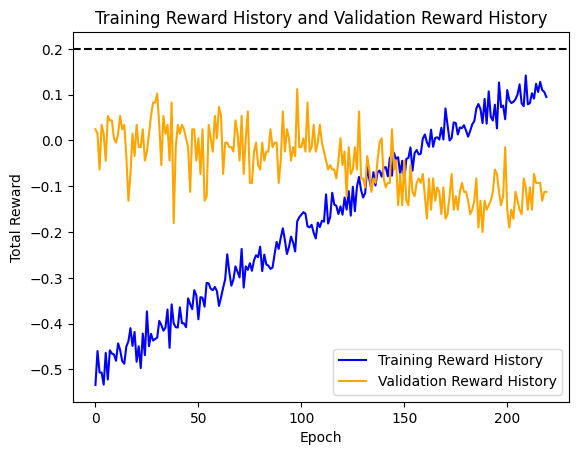

In [27]:
plt.plot(reward_history, color = 'blue', label = 'Training Reward History')
plt.plot(validation_reward_history, color = 'orange', label = 'Validation Reward History')
plt.title('Training Reward History and Validation Reward History')
plt.axhline(0.2, color = 'black', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

(array([12., 28., 15., 25., 19., 23., 22., 24., 26., 26.]),
 array([-0.53393352, -0.46634349, -0.39875346, -0.33116343, -0.26357341,
        -0.19598338, -0.12839335, -0.06080332,  0.0067867 ,  0.07437673,
         0.14196676]),
 <BarContainer object of 10 artists>)

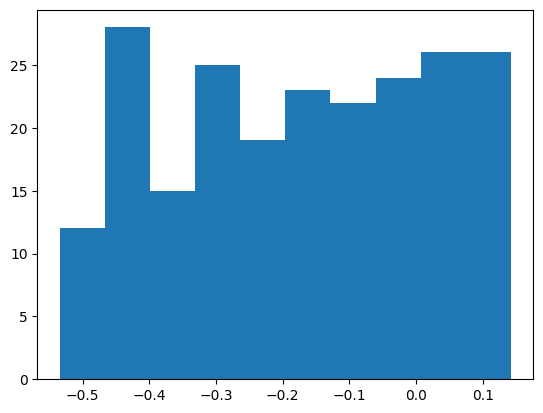

In [28]:
plt.hist(reward_history)

In [29]:
# def exponential_smooth(values, weight=0.9):
#     smoothed = [values[0]]
#     for val in values[1:]:
#         smoothed.append(weight * smoothed[-1] + (1 - weight) * val)
#     return smoothed

# smoothed_val_reward_history = exponential_smooth(validation_reward_history, weight=0.9)
# plt.plot(smoothed_val_reward_history, color='orange', label='Smoothed Validation Reward History')

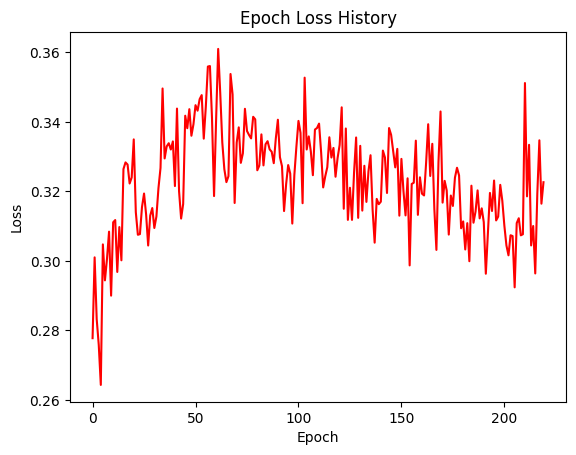

In [30]:
plt.plot(epoch_loss_history, color = 'red')
plt.title('Epoch Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [31]:
win_rates = training_metrics['win_rates']
loss_rates = training_metrics['loss_rates']
forced_rates = training_metrics['forced_rates']
none_rates = training_metrics['no_trade_rates']

print("Final win rates: ", win_rates[-1])
print("Final loss rates: ", loss_rates[-1])
print("Final forced rates: ", forced_rates[-1])
print("Final none rates: ", none_rates[-1])

training_metrics = {'win_rate': win_rates[-1],
                                 'loss_rate': loss_rates[-1],
                                 'forced_rate': forced_rates[-1],
                                 'none_rate': none_rates[-1]}

# plt.plot(win_rates, color = 'green',label = 'Win Rates')
# plt.plot(loss_rates, color = 'red', label = 'Loss Rates')
# #plt.plot(forced_rates, color = 'orange', label = 'Forced Rates')
# plt.plot(none_rates, color = 'blue', label = 'None Rates')

# plt.legend()
# plt.title('Training Metrics')
# plt.xlabel('Epoch') 
training_metrics

Final win rates:  0.5470914127423823
Final loss rates:  0.1793628808864266
Final forced rates:  0.0006925207756232687
Final none rates:  0.27285318559556787


{'win_rate': 0.5470914127423823,
 'loss_rate': 0.1793628808864266,
 'forced_rate': 0.0006925207756232687,
 'none_rate': 0.27285318559556787}

In [32]:
training_metrics

{'win_rate': 0.5470914127423823,
 'loss_rate': 0.1793628808864266,
 'forced_rate': 0.0006925207756232687,
 'none_rate': 0.27285318559556787}

# Hyper-Parameter Tuning
---

In [33]:
# best_trial, study = optimize_hyperparameters(
#     zscore_series_train, prices_train, beta_series_train,
#     zscore_series_val,   prices_val,   beta_series_val,
#     initial_capital, tx_cost,
#     entry_stop_pairs,
#     n_trials=50
# )

# Evaluate
---

In [36]:
#Recreate the model and load the saved state_dict
#online_net_trained = DQN(input_dim=6, output_dim=len(entry_stop_pairs), hidden_dim=hidden_dim_best)# Load the saved state_dict into the model
online_net_trained = DQN(input_dim=6, output_dim=len(entry_stop_pairs), hidden_dim=64)# Load the saved state_dict into the model
online_net_trained.load_state_dict(torch.load('dqn_model.pth'))



<All keys matched successfully>

In [37]:
tx_cost = 0.000

#define test environment
env_test = PairsTradingEnv(zscore_series_test, prices_test, beta_series_test, initial_capital, tx_cost, entry_stop_pairs, eval_mode=True)

#TEST SET
test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
    env_test,
    online_net_trained,
    entry_stop_pairs,
)
print(test_metrics)

#TRAINING SET

# test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
#     online_net_trained,
#     zscore_series_train,
#     prices_train,
#     beta_series_train,
#     initial_capital,
#     tx_cost,
#     entry_stop_pairs,
# )
# print(test_metrics)

#VALIDATION SET

# test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
#     online_net_trained,
#     zscore_series_val,
#     prices_val,
#     beta_series_val,
#     initial_capital,
#     tx_cost,
#     entry_stop_pairs,
# )
# print(test_metrics)



{'avg_reward': np.float64(-0.2653061224489796), 'win_rate': 0.3673469387755102, 'loss_rate': 0.2857142857142857, 'forced_rate': 0.0, 'no_trade_rate': 0.3469387755102041}


In [38]:
actions_profits_list = zip(actions,trade_profits)
actions_profits_df = pd.DataFrame(actions_profits_list, columns=['Actions', 'Trade Profits'])

#Show all rows
# pd.set_option('display.max_rows', None)=
# pd.set_option('display.max_columns', None)

# actions_profits_df_zeros = actions_profits_df[actions_profits_df['Trade Profits'] > 0]
#actions_profits_df_zeros

actions_profits_df_three_four = actions_profits_df[actions_profits_df['Actions'] == (1, 2)]
actions_profits_df_three_four.tail(50)

,Actions,Trade Profits
3,"(1, 2)",-84.773275
5,"(1, 2)",34.738940
7,"(1, 2)",42.273559
11,"(1, 2)",14.027968
12,"(1, 2)",12.141615
13,"(1, 2)",51.497380
14,"(1, 2)",-50.138069
15,"(1, 2)",58.019309
16,"(1, 2)",-44.233672
19,"(1, 2)",40.719959


Action (1, 2): 52.04%
Action (2, 3): 36.73%
Action (3, 4): 11.22%


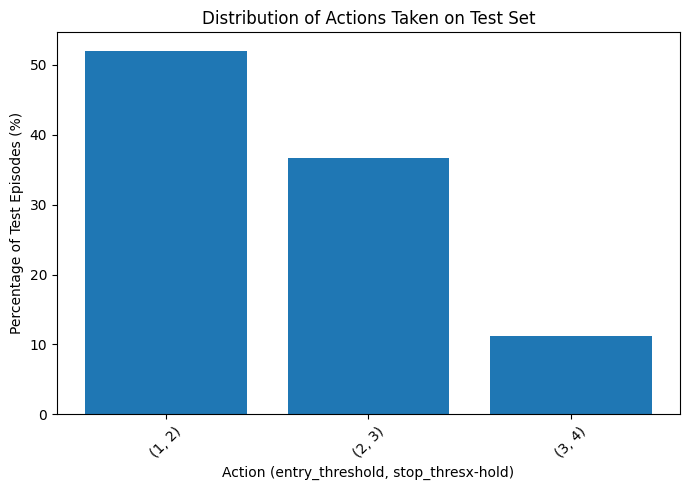

In [39]:
#Count number of each action in the actions list
from collections import Counter

# 1. Count how many times each action appears
counts = Counter(actions)
total = len(actions)

# 2. Compute percentages
actions_sorted = sorted(counts.keys())
percentages = [counts[a] / total * 100 for a in actions_sorted]

actions_percentages_zip = zip(actions_sorted, percentages)

# 3. Print the results
for action, percentage in actions_percentages_zip:
    print(f"Action {action}: {percentage:.2f}%")

# 4. Plot the distribution
plt.figure(figsize=(7, 5))
plt.bar(range(len(actions_sorted)), percentages)
plt.xticks(range(len(actions_sorted)), [f"{a}" for a in actions_sorted], rotation=45)
plt.ylabel("Percentage of Test Episodes (%)")
plt.xlabel("Action (entry_threshold, stop_thresx-hold)")
plt.title("Distribution of Actions Taken on Test Set")
plt.tight_layout()
plt.show()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  2.,  0.,  2.,  1.,  2.,  3.,  2.,  3.,  2.,
         3.,  4.,  2.,  0.,  4., 35.,  1.,  3.,  4.,  3.,  6.,  3.,  5.,
         2.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-167.03818645, -161.66771059, -156.29723473, -150.92675887,
        -145.55628301, -140.18580715, -134.8153313 , -129.44485544,
        -124.07437958, -118.70390372, -113.33342786, -107.962952  ,
        -102.59247614,  -97.22200028,  -91.85152443,  -86.48104857,
         -81.11057271,  -75.74009685,  -70.36962099,  -64.99914513,
         -59.62866927,  -54.25819342,  -48.88771756,  -43.5172417 ,
         -38.14676584,  -32.77628998,  -27.40581412,  -22.03533826,
         -16.6648624 ,  -11.29438655,   -5.92391069,   -0.55343483,
           4.81704103,   10.18751689,   15.55799275,   20.92846861,
          26.29894446,   31.66942032,   37.03989618,   42.41037204,
          47.7808479 ,   53.15132376

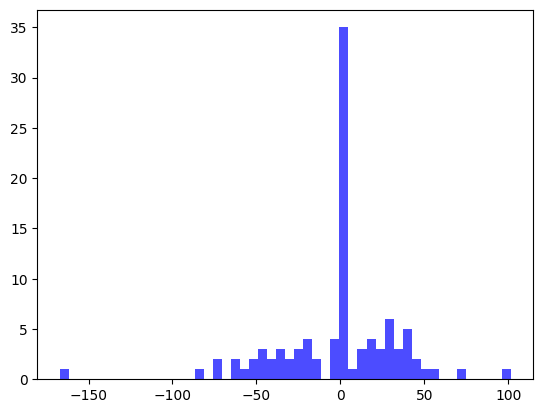

In [40]:
plt.hist(trade_profits, bins=50, color='blue', alpha=0.7)

Final returns:  -2.0319151596997003 %


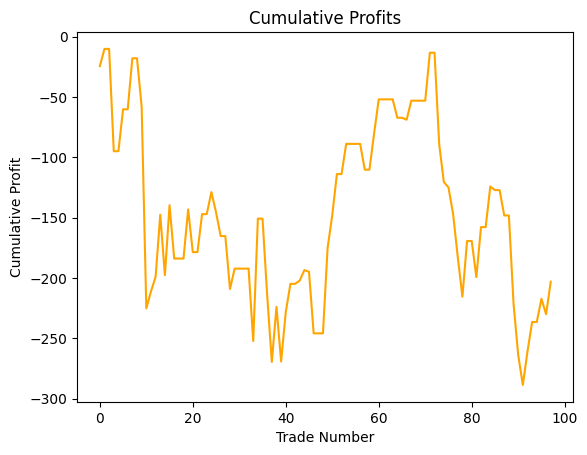

In [41]:
cumulative_profits = np.cumsum(trade_profits)
final_return_test_set = (cumulative_profits[-1]/initial_capital) * 100
print("Final returns: ", final_return_test_set, "%")
plt.plot(cumulative_profits, color='orange')
plt.title('Cumulative Profits')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Profit')
plt.show()

Number of trades:  95
Percentage_Return:  9.862947065413522 %


/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_35687/4177828696.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Percentage_Return: ", (cumulative_profit_series_no_agent[-1] / initial_capital) * 100,"%")


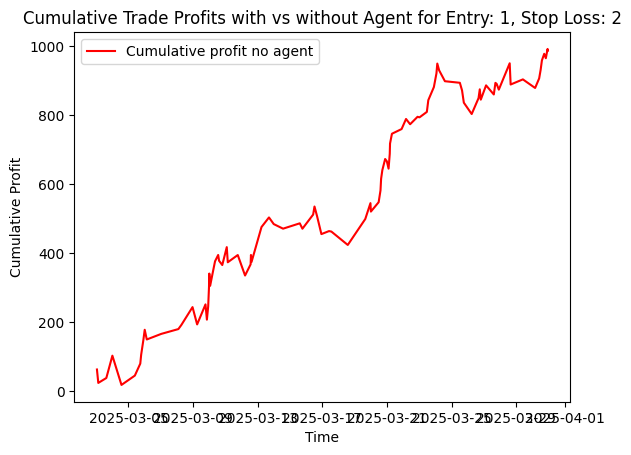

Number of trades:  47
Percentage_Return:  -2.343526683987972 %


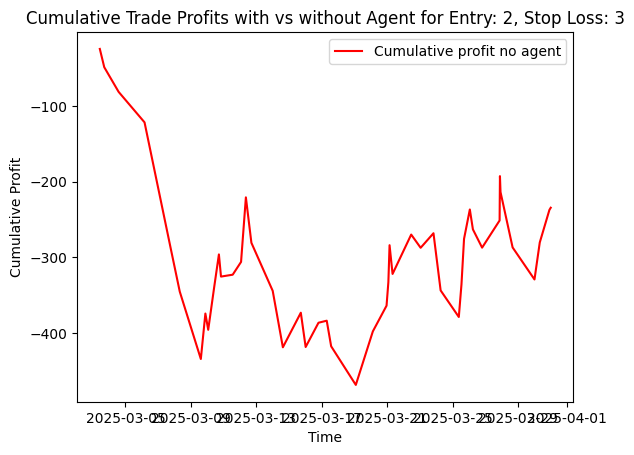

Number of trades:  16
Percentage_Return:  -1.1679564174631194 %


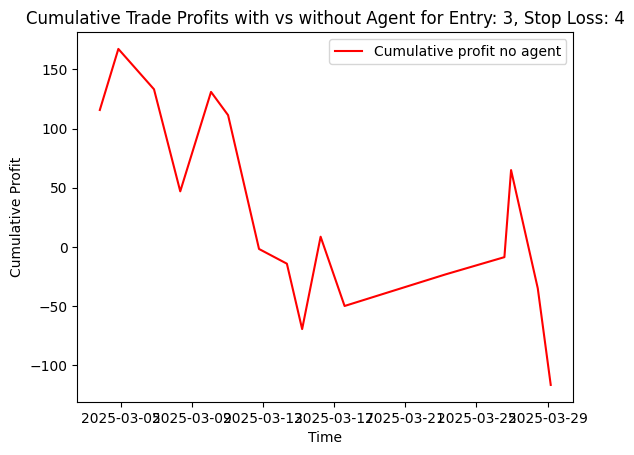

Number of trades:  5
Percentage_Return:  -0.45651515371821105 %


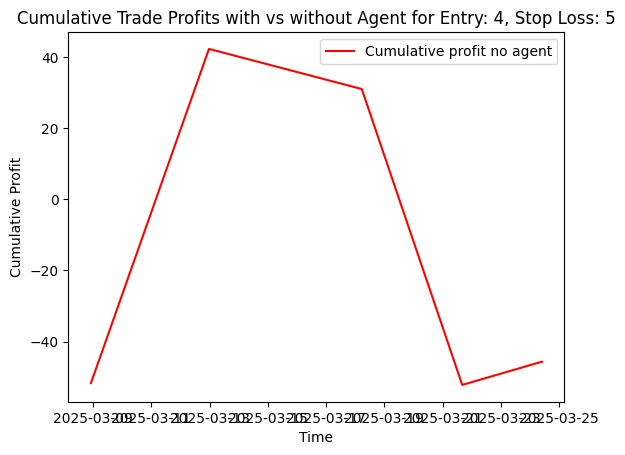

In [42]:

exit_threshold = 0
#tx_cost = 0.00025

#entry_stop_pairs = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]

for entry_stop_pair in entry_stop_pairs:
    entry_threshold, stop_loss_threshold = entry_stop_pair
    
    #TEST DATA
    #----------
    positions, trade_entries, trade_exits = backtest_pair_rolling(S1_test,S2_test,zscore_series_test, entry_threshold, exit_threshold, stop_loss_threshold)
    trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_test, tx_cost)

    # #TRAIN DATA
    # #----------
    # positions, trade_entries, trade_exits = backtest_pair_rolling(S1_train,S2_train,zscore_series_train, entry_threshold, exit_threshold, stop_loss_threshold)
    # trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_train, tx_cost)

    #VAL DATA
    #----------
    # positions, trade_entries, trade_exits = backtest_pair_rolling(S1_val,S2_val,zscore_series_val, entry_threshold, exit_threshold, stop_loss_threshold)
    # trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_val, tx_cost)

    #print(trade_profits_no_agent)
    #cumulative_profit_series_no_agent_indexed = cumulative_profit_series_no_agent.reindex(prices_test.index, method='ffill').fillna(0)
    print("Number of trades: ", len(trade_profits_no_agent))
    #print(cumulative_profit_series_no_agent)
    plt.plot(cumulative_profit_series_no_agent, color = 'red', label = 'Cumulative profit no agent') #Cumulative profits without agent
    print("Percentage_Return: ", (cumulative_profit_series_no_agent[-1] / initial_capital) * 100,"%")
    plt.title(f'Cumulative Trade Profits with vs without Agent for Entry: {entry_threshold}, Stop Loss: {stop_loss_threshold}')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Profit')
    plt.legend()
    plt.show()

# Case study
---

In [39]:
episodes[2]['cycle_idx']

3

In [ ]:
env_test

In [46]:
env_test.spread_cycles[2]

timestamp
2025-03-03 12:05:00    1.068588
2025-03-03 12:10:00    0.683048
2025-03-03 12:15:00    0.396802
2025-03-03 12:20:00    0.277631
2025-03-03 12:25:00    0.701863
                         ...   
2025-03-03 19:40:00    1.287273
2025-03-03 19:45:00    1.095666
2025-03-03 19:50:00    0.571962
2025-03-03 19:55:00    0.030288
2025-03-03 20:00:00   -0.038746
Length: 96, dtype: float64

In [50]:
episodes[1]['exit_meta']['exit_type']

'loss'

In [53]:
len(env_test.spread_cycles)

99

99

In [66]:
episodes[11]

{'cycle_idx': 12,
 'entry_meta': None,
 'exit_meta': None,
 'entry_threshold': 2,
 'stop_threshold': 3}

In [88]:
#Analyze properties of cycles that were lost:

chosen_vs_best_pairs = []

for episode in (episodes):


    if episode['exit_meta'] != None and episode['exit_meta']['exit_type'] == 'loss':
        
        
        #Get the index of the traded cycle
        episode_cycle_index = episode['cycle_idx'] #The spread cycle that was traded in this index

        #Get the threshold chosen for this cycle
        chosen_entry, chosen_stop = episode['entry_threshold'], episode['stop_threshold'] #The entry and stop thresholds chosen for this cycle

        chosen_entry_stop_pair = (chosen_entry, chosen_stop)

        #Get the best threshold pair for this cycle
        best_entry_stop_pair = env_test.best_pairs[episode_cycle_index]


        chosen_vs_best_pairs.append((chosen_entry_stop_pair, env_test.best_pairs[episode_cycle_index]))

       

        # cycle = env_test.spread_cycles[episode_cycle_index] #The actual cycle

print("Chosen vs Best Pairs for Loss Cycles")
print("------------------------------")
chosen_vs_best_pairs



Chosen vs Best Pairs for Loss Cycles
------------------------------


[((1, 2), (3, 4)),
 ((1, 2), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (4, 5)),
 ((1, 2), (3, 4)),
 ((2, 3), (3, 4)),
 ((3, 4), (4, 5)),
 ((1, 2), (3, 4)),
 ((1, 2), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (3, 4)),
 ((1, 2), (2, 3)),
 ((3, 4), (4, 5)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((2, 3), (4, 5)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (3, 4)),
 ((1, 2), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3))]

In [82]:
one_two_counter = 0
two_three_counter = 0
three_four_counter = 0
four_five_counter = 0   

for chosen_pair , best_pair in chosen_vs_best_pairs:

    if chosen_pair == (1, 2) and best_pair == (1, 2):
        one_two_counter += 1
    elif chosen_pair == (2, 3) and best_pair == (2, 3):
        two_three_counter += 1
    elif chosen_pair == (3, 4) and best_pair == (3, 4):
        three_four_counter += 1
    elif chosen_pair == (4, 5) and best_pair == (4, 5):
        four_five_counter += 1

print("------------------------------")
print(f"Chosen (1, 2) vs Best (1, 2): {one_two_counter}")
print(f"Chosen (2, 3) vs Best (2, 3): {two_three_counter}")
print(f"Chosen (3, 4) vs Best (3, 4): {three_four_counter}")
print(f"Chosen (4, 5) vs Best (4, 5): {four_five_counter}")
    


------------------------------
Chosen (1, 2) vs Best (1, 2): 22
Chosen (2, 3) vs Best (2, 3): 9
Chosen (3, 4) vs Best (3, 4): 4
Chosen (4, 5) vs Best (4, 5): 0


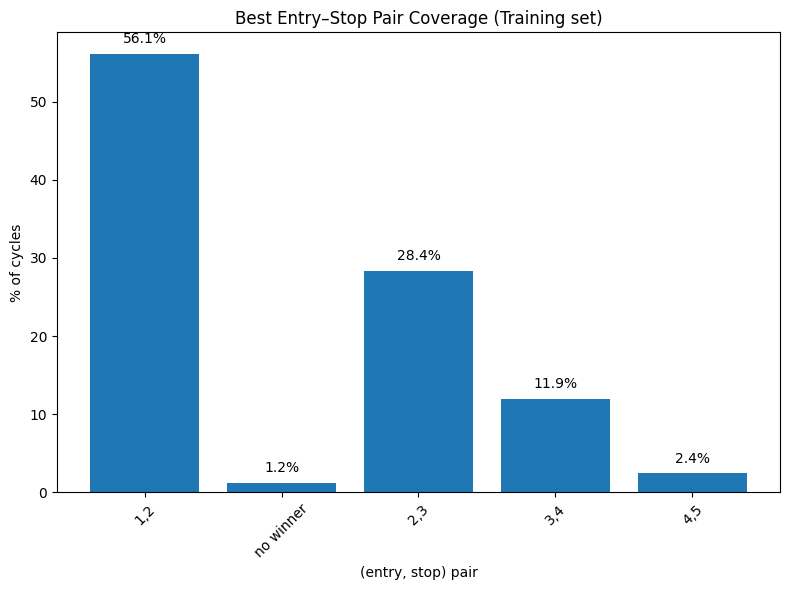

In [ ]:
#Compare distirbution of best_pairs in training set and testing set
training_env = PairsTradingEnv(
        zscore_series_train, prices_train, beta_series_train,
        initial_capital, tx_cost,
        entry_stop_pairs,
        eval_mode=False) #Set eval_mode to False for training

#Plot distribution of best pairs in training set
training_best_pairs = training_env.best_pairs
training_counts = Counter(training_best_pairs)
# Convert raw counts to percentages
training_pairs = list(training_counts.keys())
training_percentages = [training_counts[p] / len(training_best_pairs) * 100 for p in training_pairs]
# Turn None → a string label
training_labels = [
    "no winner" if p is None else f"{p[0]},{p[1]}"
    for p in training_pairs
]
# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(training_labels)), training_percentages, tick_label=training_labels)
plt.ylabel("% of cycles")
plt.xlabel("(entry, stop) pair")
# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')
plt.xticks(rotation=45)
plt.title("Best Entry–Stop Pair Coverage (Training set)")
plt.tight_layout()


In [89]:
training_best_pairs

[(1, 2),
 (1, 2),
 None,
 (2, 3),
 (2, 3),
 (2, 3),
 (1, 2),
 (3, 4),
 (1, 2),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (2, 3),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (1, 2),
 (1, 2),
 (2, 3),
 (2, 3),
 (3, 4),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (3, 4),
 (3, 4),
 (2, 3),
 (1, 2),
 (3, 4),
 (1, 2),
 (1, 2),
 (1, 2),
 (3, 4),
 (3, 4),
 (2, 3),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (4, 5),
 (3, 4),
 (4, 5),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (2, 3),
 (3, 4),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (4, 5),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (2, 3),
 (2, 3),
 (1, 2),
 (2, 3),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (3, 4),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1

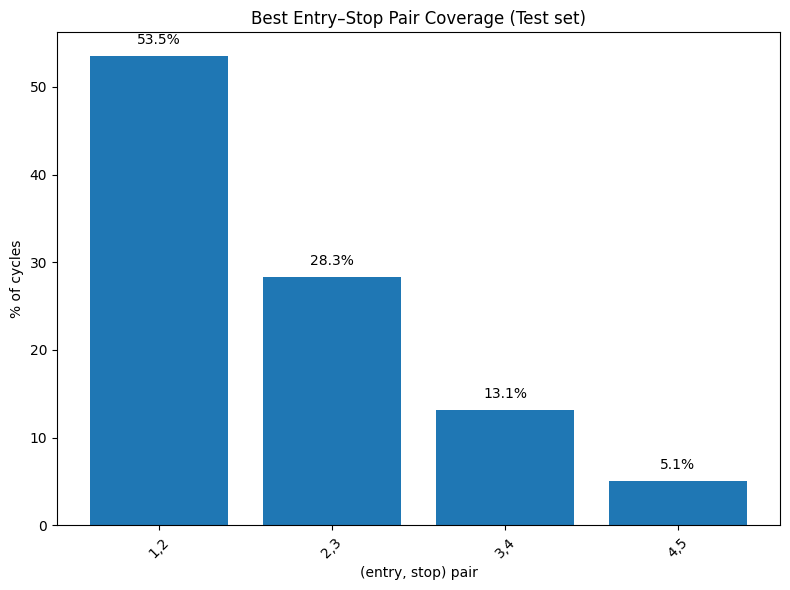

In [87]:
testing_best_pairs = env_test.best_pairs
testing_counts = Counter(testing_best_pairs)
# Convert raw counts to percentages
testing_pairs = list(testing_counts.keys())
testing_percentages = [testing_counts[p] / len(testing_best_pairs) * 100 for p in testing_pairs]
# Turn None → a string label
testing_labels = [
    "no winner" if p is None else f"{p[0]},{p[1]}"
    for p in testing_pairs
]
# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(testing_labels)), testing_percentages, tick_label=testing_labels)
plt.ylabel("% of cycles")
plt.xlabel("(entry, stop) pair")
# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')
plt.xticks(rotation=45)
plt.title("Best Entry–Stop Pair Coverage (Test set)")
plt.tight_layout()

# Save final results 
---

In [42]:
# #Create a dataframe to store the number of epochs, trials, best hyperparameters, best reward, training metrics and test metrics
# df_results = pd.DataFrame({
#     'num_epochs': [num_epochs],
#     'n_trials': [n_trials],
#     'best_hyperparameters': [best_params],
#     'best_validation_reward': [best_reward],
#     'training_metrics': [training_metrics],
#     'test_metrics': [test_metrics],
#     'final_return_test_set (%)': [final_return_test_set]
# })
  

In [43]:
# df_results.to_csv('results/reinforcement_learning/MANAUSDT_SANDUSDT_results.csv', header=False, mode='a', index=False)

In [44]:
# read_test = pd.read_csv('results/reinforcement_learning/MANAUSDT_SANDUSDT_results.csv', parse_dates=True)
# read_test